### NLP Tasks with Simple Interface

We will create Two Apps 
- Text Summarization
- Named Entity Recognition

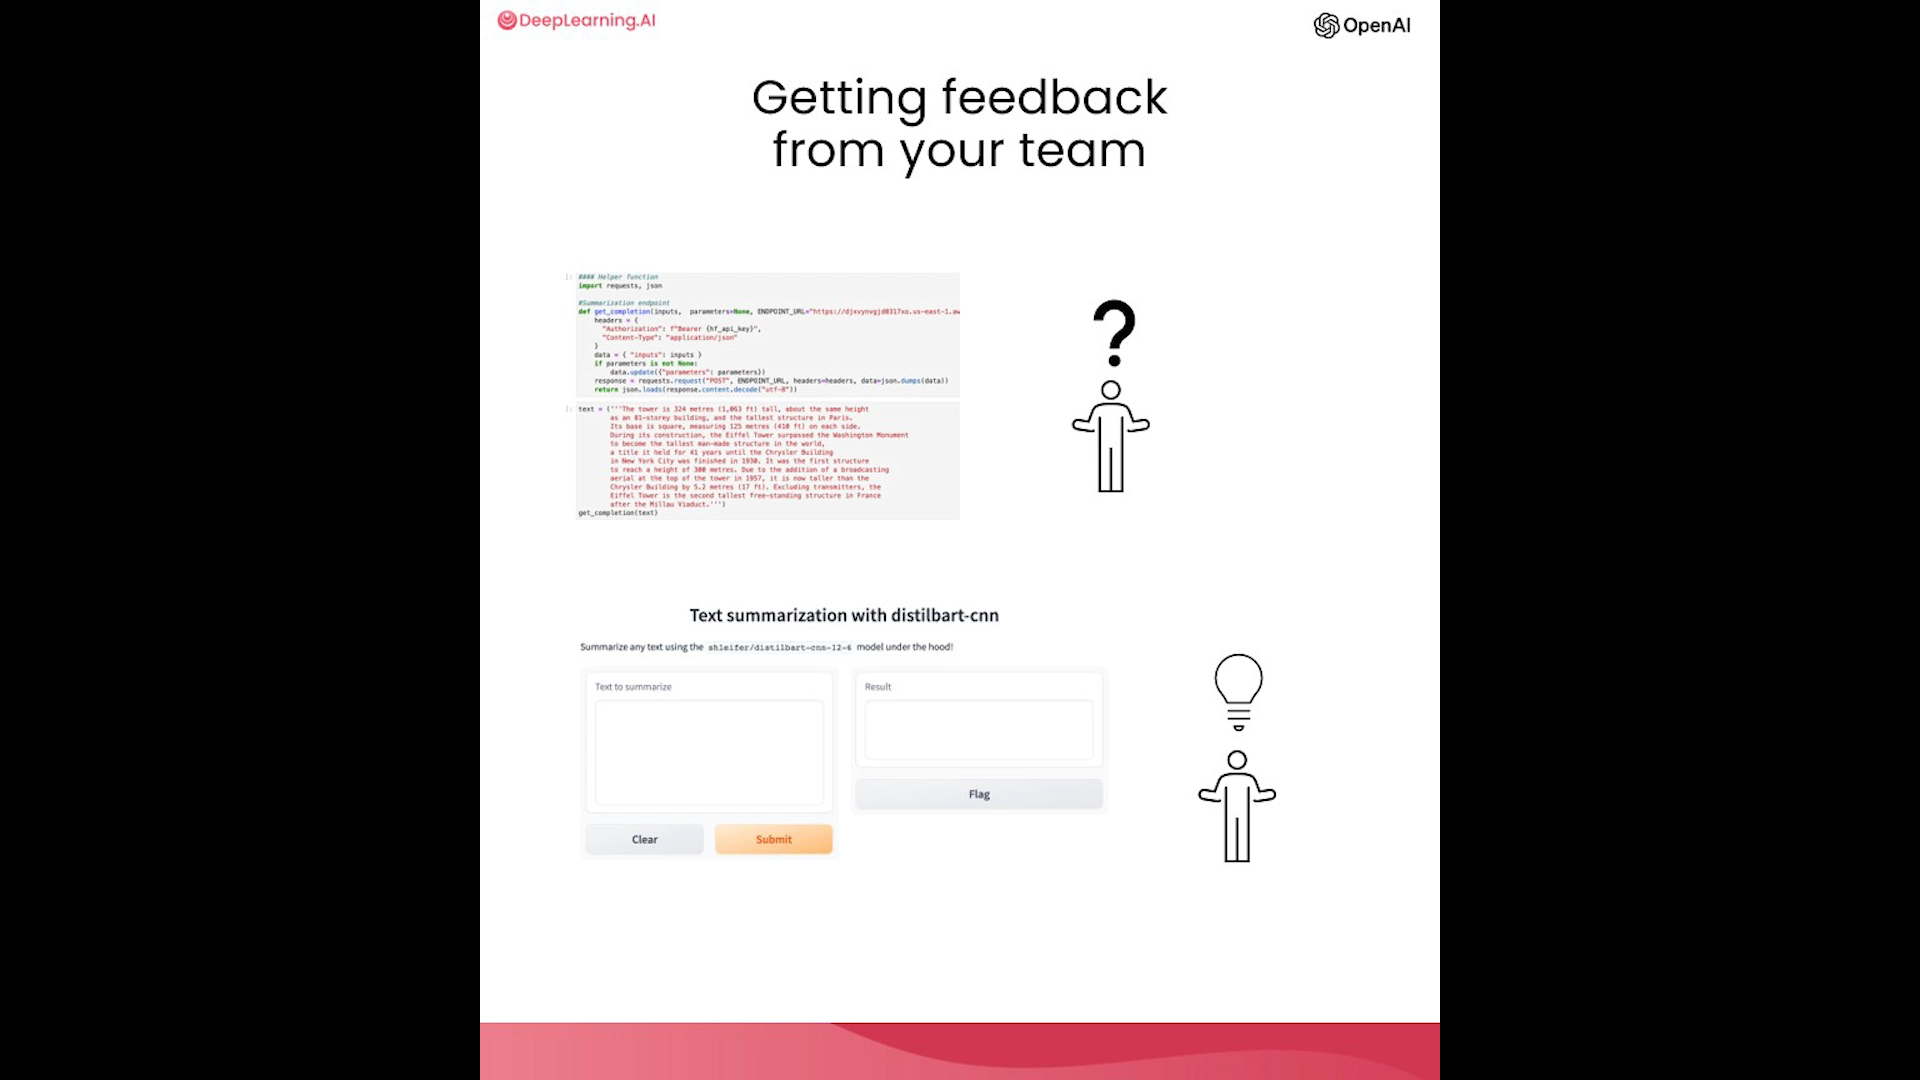

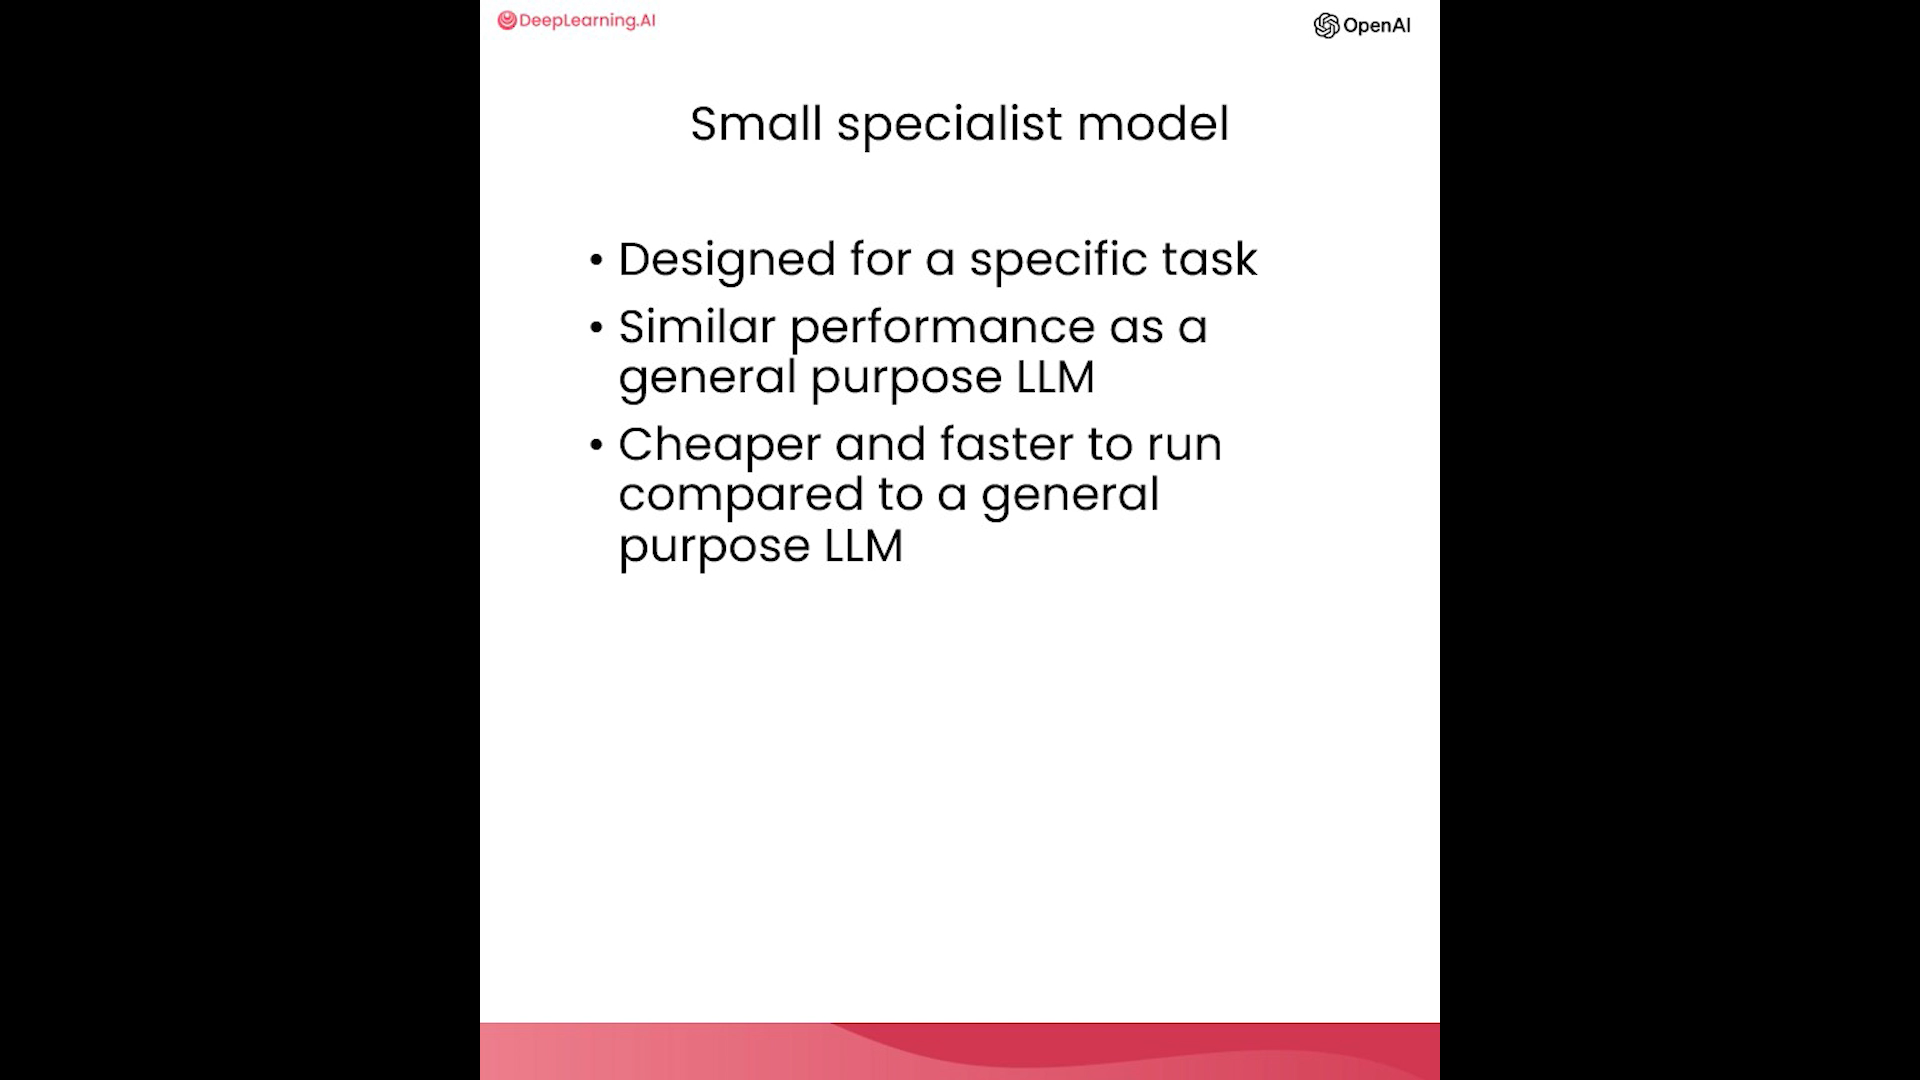

In [11]:
import os
import io
from IPython.display import Image, display, HTML
from PIL import Image
import base64 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

In [2]:
# Helper function
import requests, json

#Summarization endpoint
def get_completion(inputs, parameters=None,ENDPOINT_URL=os.environ['HF_API_SUMMARY_BASE']): 
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.request("POST",
                                ENDPOINT_URL, headers=headers,
                                data=json.dumps(data)
                               )
    return json.loads(response.content.decode("utf-8"))

### How about running it locally?
The code would look very similar if you were running it locally instead of from an API. The same is true for all the models in the rest of the course, make sure to check the [Pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines) documentation page

```py
from transformers import pipeline

get_completion = pipeline("summarization", model="shleifer/distilbart-cnn-12-6")

def summarize(input):
    output = get_completion(input)
    return output[0]['summary_text']
    
```

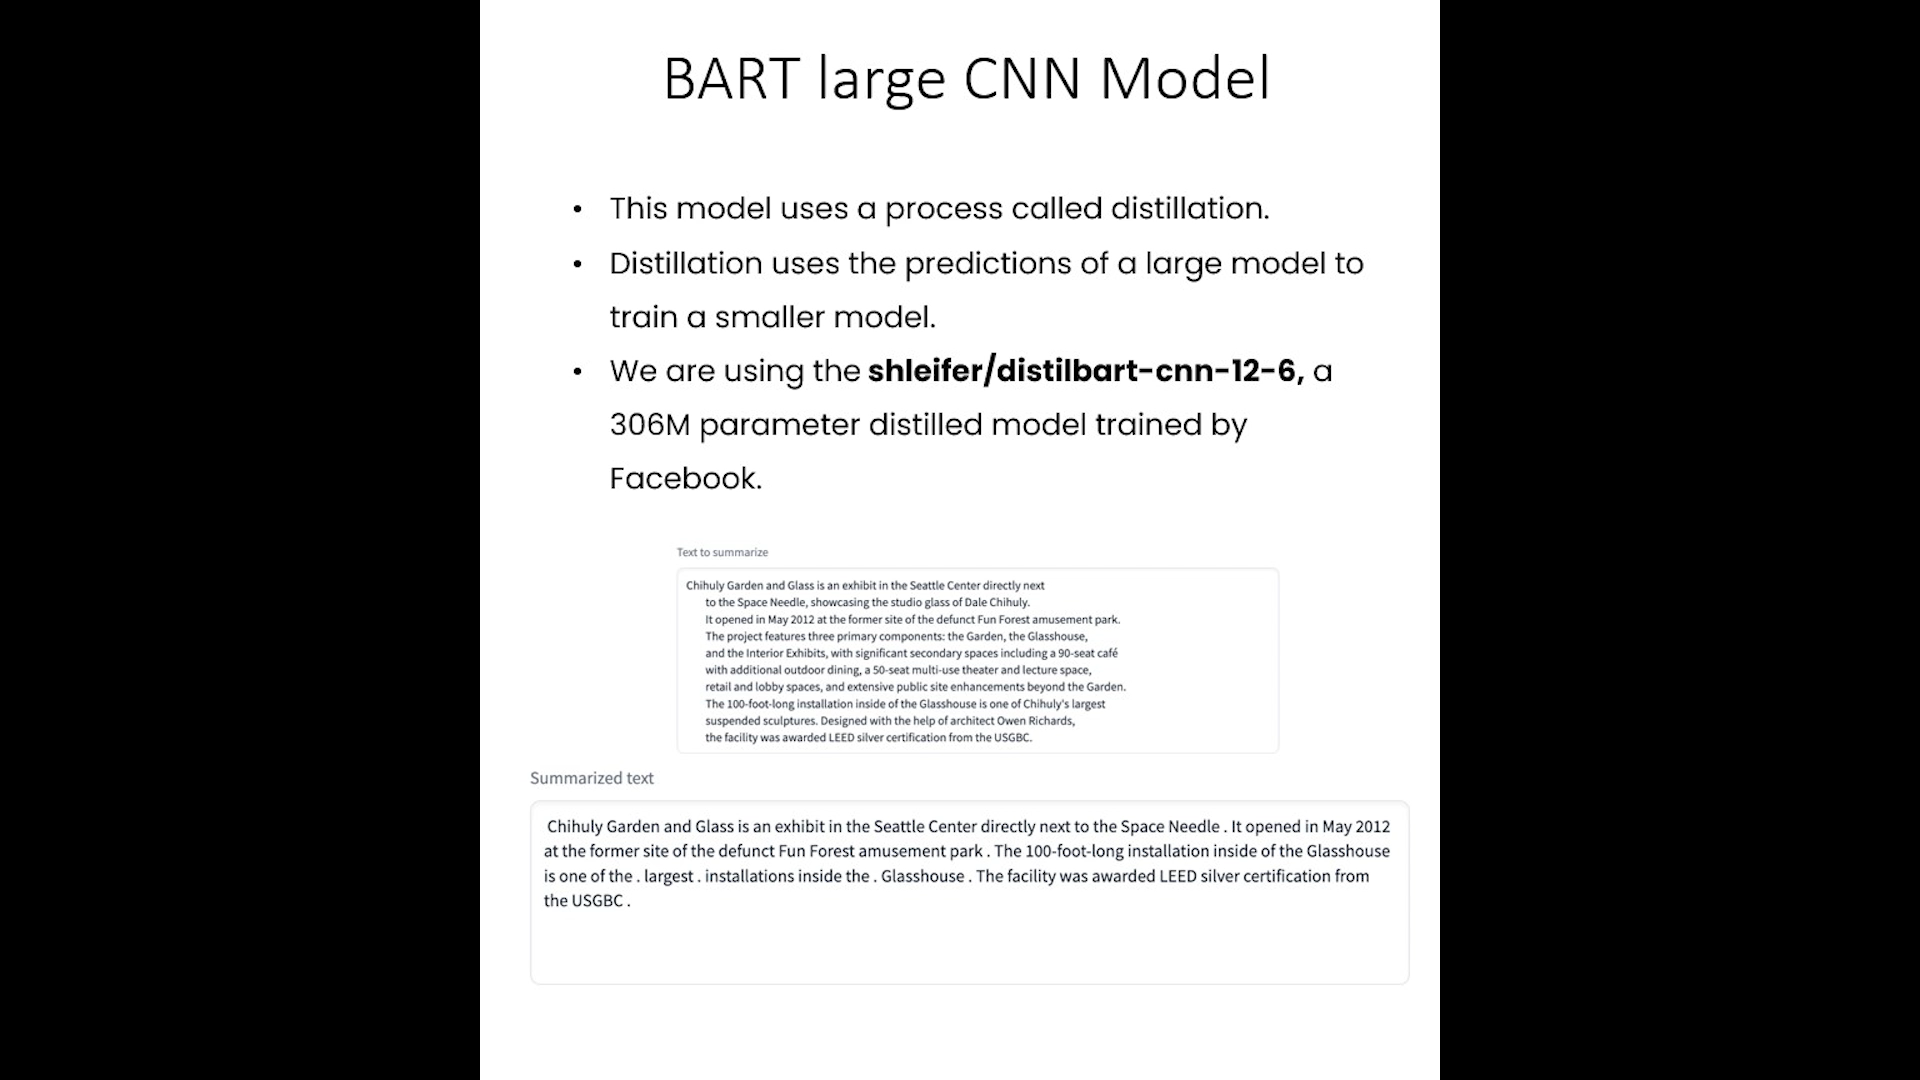

### Building a text summarization app

In [3]:
from transformers import pipeline

pipeine_summarize = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def get_completion(input):
    output = pipeine_summarize(input)
    return output[0]['summary_text']

e:\Github\LLM\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
text = ('''The tower is 324 metres (1,063 ft) tall, about the same height
        as an 81-storey building, and the tallest structure in Paris. 
        Its base is square, measuring 125 metres (410 ft) on each side. 
        During its construction, the Eiffel Tower surpassed the Washington 
        Monument to become the tallest man-made structure in the world,
        a title it held for 41 years until the Chrysler Building
        in New York City was finished in 1930. It was the first structure 
        to reach a height of 300 metres. Due to the addition of a broadcasting 
        aerial at the top of the tower in 1957, it is now taller than the 
        Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the 
        Eiffel Tower is the second tallest free-standing structure in France 
        after the Millau Viaduct.''')

get_completion(text)

' The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building . It is the tallest structure in Paris and the second tallest free-standing structure in France after the Millau Viaduct . It was the first structure in the world to reach a height of 300 metres .'

### Getting started with Gradio `gr.Interface` 

In [7]:
import gradio as gr
gr.close_all()
demo = gr.Interface(fn=get_completion, 
                    inputs=[gr.Textbox(label="Text to summarize", lines=6)],
                    outputs=[gr.Textbox(label="Result", lines=3)],
                    title="Text summarization with distilbart-cnn",
                    description="Summarize any text using the `shleifer/distilbart-cnn-12-6` model under the hood!"
                   )
demo.launch(share=False, server_port=int(os.environ['PORT1']))

### `demo.launch(share=True)` lets you create a public link to share with your team or friends.

Closing server running on port: 8081
Running on local URL:  http://127.0.0.1:8081

To create a public link, set `share=True` in `launch()`.


### Building a Named Entity Recognition app

In [9]:
from transformers import pipeline

get_completion = pipeline("ner", model="dslim/bert-base-NER")

def ner(input):
    output = get_completion(input)
    return {"text": input, "entities": output}
gr.close_all()
demo = gr.Interface(fn=ner,
                    inputs=[gr.Textbox(label="Text to find entities", lines=2)],
                    outputs=[gr.HighlightedText(label="Text with entities")],
                    title="NER with dslim/bert-base-NER",
                    description="Find entities using the `dslim/bert-base-NER` model under the hood!",
                    allow_flagging="never",
                    #Here we introduce a new tag, examples, easy to use examples for your application
                    examples=["My name is Andrew and I live in California", "My name is Poli and work at HuggingFace"])
demo.launch(share=False, server_port=int(os.environ['PORT2']))

config.json: 100%|██████████| 829/829 [00:00<00:00, 830kB/s]
e:\Github\LLM\.conda\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
model.safetensors: 100%|██████████| 433M/433M [01:20<00:00, 5.36MB/s] 
Some weights of the m

Closing server running on port: 8081
Closing server running on port: 8081
Running on local URL:  http://127.0.0.1:8081

To create a public link, set `share=True` in `launch()`.


### Adding a helper function to merge tokens

In [15]:
def merge_tokens(tokens):
    merged_tokens = []
    for token in tokens:
        if merged_tokens and token['entity'].startswith('I-') and merged_tokens[-1]['entity'].endswith(token['entity'][2:]):
            # If current token continues the entity of the last one, merge them
            last_token = merged_tokens[-1]
            last_token['word'] += token['word'].replace('##', '')
            last_token['end'] = token['end']
            last_token['score'] = (last_token['score'] + token['score']) / 2
        else:
            # Otherwise, add the token to the list
            merged_tokens.append(token)

    return merged_tokens

def ner(input):
    output = get_completion(input)
    merged_tokens = merge_tokens(output)
    return {"text": input, "entities": merged_tokens}

gr.close_all()
demo = gr.Interface(fn=ner,
                    inputs=[gr.Textbox(label="Text to find entities", lines=2)],
                    outputs=[gr.HighlightedText(label="Text with entities")],
                    title="NER with dslim/bert-base-NER",
                    description="Find entities using the `dslim/bert-base-NER` model under the hood!",
                    allow_flagging="never",
                    examples=["My name is Andrew, I'm building DeeplearningAI and I live in California", "My name is Poli, I live in Vienna and work at HuggingFace"])

demo.launch(share=False, server_port=int(os.environ['PORT3']))

Closing server running on port: 8083
Closing server running on port: 8081
Closing server running on port: 8081
Closing server running on port: 8081
Closing server running on port: 8083
Closing server running on port: 8083
Running on local URL:  http://127.0.0.1:8083

To create a public link, set `share=True` in `launch()`.


In [16]:

gr.close_all()

Closing server running on port: 8083
Closing server running on port: 8081
Closing server running on port: 8081
Closing server running on port: 8081
Closing server running on port: 8083
Closing server running on port: 8083
Closing server running on port: 8083
